## Prepare TADPOLE data

### Training data

In [1]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

import seaborn as sns

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [545]:
path = '/network/lustre/dtlake01/aramis/datasets/adni/leaspy/raw/TADPOLE_2019_12_10/tadpole_challenge/'

In [601]:
columns = ['RID', 'AGE', 'Month', 'Hippocampus', 'Ventricles', 'ADAS13', 'ICV', 'EXAMDATE']
D1 = pd.read_csv(path+'TADPOLE_D1_D2.csv', usecols = columns)
D1_original = D1.copy()
D1['TIME'] = D1['AGE'] + D1['Month']/12
D1 = D1.rename(columns={'RID':'ID'})
ExamDates = D1.set_index(['ID', 'TIME'])['EXAMDATE']
D1 = D1.set_index('ID').drop('EXAMDATE', axis=1)
D1

,AGE,ADAS13,Ventricles,Hippocampus,ICV,Month,TIME
ID,,,,,,,
2,74.3,18.67,118233.0,8336.0,1984660.0,0,74.3
3,81.3,31.00,84599.0,5319.0,1920690.0,0,81.3
3,81.3,30.00,88580.0,5446.0,1906430.0,6,81.8
3,81.3,35.00,90099.0,5157.0,1903820.0,12,82.3
3,81.3,37.67,97420.0,5139.0,1903420.0,24,83.3
...,...,...,...,...,...,...,...
4167,69.5,NaN,NaN,NaN,NaN,60,74.5
4199,59.0,12.00,NaN,NaN,NaN,60,64.0
4557,83.3,22.00,NaN,NaN,NaN,60,88.3


In [602]:
D1_clean = pd.DataFrame(columns=D1.columns)
for sub in D1.index.unique():
    data_sub = D1.loc[sub]
    if type(data_sub) != pd.core.series.Series:
        data_sub = data_sub.dropna(thresh=4)
    data_sub = data_sub.fillna(data_sub.mean())
    D1_clean = D1_clean.append(data_sub)
    
D1 = D1_clean
D1['ID'] = D1.index
D1 = D1.set_index(['ID', 'TIME'])
D1 = D1[~D1.index.duplicated(keep='first')]

D1

AGE  ADAS13     Ventricles  Hippocampus        ICV Month
ID   TIME                                                           
2    74.3  74.3   18.67  118233.000000       8336.0  1984660.0     0
     74.8  74.3   19.67  118233.000000       8336.0  1984660.0     6
     77.3  74.3   20.00  118233.000000       8336.0  1984660.0    36
     79.3  74.3   23.00  118233.000000       8336.0  1984660.0    60
     80.3  74.3   21.00  118233.000000       8336.0  1984660.0    72
...         ...     ...            ...          ...        ...   ...
5295 77.5  75.5   18.00            NaN       5928.0  1429360.0    24
5296 69.3  69.3   14.00   18633.000000      10602.0  1998250.0     0
     71.3  69.3   15.00   18633.000000      10602.0  1998250.0    24
4264 74.1  74.1    6.00   50196.000000       6254.0  1415770.0   0.0
4740 88.3  88.3   41.00  280912.933333       6480.0  1678780.0   0.0

[9665 rows x 6 columns]

In [603]:
D1['Hippocampus'] = D1['Hippocampus']/D1['ICV']
D1['Ventricles'] = D1['Ventricles']/D1['ICV']
D1 = D1.drop(['ICV', 'AGE', 'Month'], axis=1)

In [452]:
D1['ADAS13'] /= 50
D1['Ventricles'] /= 0.06
D1['Hippocampus'] /= 0.008

for visit in D1.index:
    adas, ven, hip = D1.loc[visit].values
    if (hip > 1.05) or (ven > 1.2) or (adas > 1.2):
        D1 = D1.drop(visit)
        
D1['Hippocampus'] = 1 - D1['Hippocampus']

array([[<AxesSubplot:title={'center':'ADAS13'}>,
        <AxesSubplot:title={'center':'Ventricles'}>],
       [<AxesSubplot:title={'center':'Hippocampus'}>, <AxesSubplot:>]],
      dtype=object)

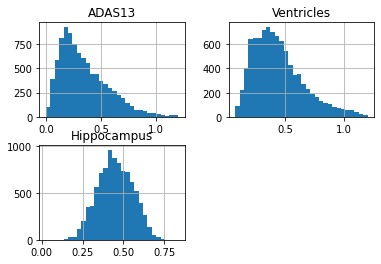

In [453]:
for sub in D1.index.get_level_values(0).unique():
    if len(D1.loc[sub]) < 2:
        D1 = D1.drop(sub, level=0)
        
D1 = D1.sort_index()
D1.hist(bins=30)

In [454]:
D1.describe()

,ADAS13,Ventricles,Hippocampus
count,9461.000000,9405.000000,9285.000000
mean,0.342091,0.443136,0.449653
std,0.219350,0.215317,0.106035
min,0.000000,0.075044,0.025325
25%,0.180000,0.282726,0.374377
50%,0.293400,0.403968,0.447934
75%,0.473333,0.557456,0.526661
max,1.200000,1.196734,0.835764


In [458]:
D1 = D1.fillna(D1.mean())

In [459]:
D1.to_csv('tadpole/data/D1.csv')

In [460]:
X = np.array(D1.index.get_level_values(1))
Y = D1.values
group = np.array(D1.index.get_level_values(0))

In [461]:
data_path = 'tadpole/data/'
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

In [550]:
D1 = pd.read_csv('tadpole/data/D1.csv').set_index(['ID', 'TIME'])
D1

ADAS13  Ventricles  Hippocampus
ID   TIME                                 
2    74.3  0.3734    0.992890     0.474973
     74.8  0.3934    0.992890     0.474973
     77.3  0.4000    0.992890     0.474973
     79.3  0.4600    0.992890     0.474973
     80.3  0.4200    0.992890     0.474973
...           ...         ...          ...
5294 71.0  0.1800    0.256293     0.286861
5295 75.5  0.3600    0.443136     0.481586
     77.5  0.3600    0.443136     0.481586
5296 69.3  0.2800    0.155411     0.336795
     71.3  0.3000    0.155411     0.336795

[9461 rows x 3 columns]

## Evaluate reconstruction error

In [2]:
path = 'tadpole/'
output_folder = 'output/'

In [3]:
rer = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
       allow_pickle=True)[()]
ids = pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

In [4]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

In [5]:
# Then in the required format for the deformetrica model

rer['onset_age'] = rer['onset_age'].mean(axis=0)
rer['log_acceleration'] = rer['log_acceleration'].mean(axis=0)
rer['sources'] = np.array([[source] for source in rer['sources'].mean(axis=0)])
averaged_rer = rer
averaged_rer

{'onset_age': array([68.74500267, 64.79041987, 75.8695855 , 76.44132701, 72.21114414,
        82.46241576, 80.00261904, 80.41428171, 93.87116737, 78.21782536,
        85.56113673, 87.29574462, 86.31669444, 75.33447423, 70.74855594,
        80.95988523, 81.53596091, 67.4915806 , 63.82293425, 69.61978162,
        88.10689594, 88.02933312, 92.06306374, 75.6490026 , 82.10961771,
        84.81922117, 80.55530129, 83.7684479 , 78.80825558, 84.34117317,
        73.30785176, 74.82885534, 72.8373239 , 72.72094585, 70.01477363,
        68.76870217, 68.83427094, 83.26626561, 80.64277582, 73.58281983,
        77.00065333, 76.33053482, 69.75186558, 73.536048  , 81.4874407 ,
        79.37802301, 75.02262737, 81.8984559 , 84.42092805, 75.84601632,
        71.49675262, 75.44043632, 70.96651887, 66.25156956, 88.23386341,
        84.19671035, 75.63899686, 71.04343026, 72.18313341, 89.47401147,
        86.90122557, 71.58789818, 70.92971654, 70.44698054, 72.50987037,
        86.54835624, 70.51826008, 71.6

In [6]:
# First we put them in a dataframe for visualization purpose

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])
ip['tau'] = rer['onset_age'].mean(axis=1)
ip['xi'] = rer['log_acceleration'].mean(axis=0)
ip['source'] = rer['sources'].mean(axis=1)

ip

AxisError: axis 1 is out of bounds for array of dimension 1

In [7]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])

ip['tau'] = tau
ip['xi'] = xi
ip['source'] = sources

ip

/tmp/ipykernel_2648412/1755275170.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]


,tau,xi,source
3,61.432639,0.164084,-0.135234
4,64.460305,0.106747,0.481641
5,80.399463,-1.247760,-0.054991
6,77.437032,0.266354,0.847986
10,71.780770,-0.236618,1.632855
...,...,...,...
4989,85.743556,-0.656312,0.587627
5066,69.469092,-0.690720,-0.249059
5079,82.266332,-0.104291,-0.172894
5082,75.993014,0.227735,-1.415186


In [8]:
path = 'tadpole'
data = '/data'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
adas = [score[0] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ven = [score[1] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
hip = [score[2] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [9]:
data = pd.DataFrame(index=[ids, times], columns=['hip', 'ven', 'adas'])
data['hip'] = hip
data['ven'] = ven
data['adas'] = adas
data.index.set_names(['ID','TIME'], inplace=True)
data

hip       ven    adas
ID   TIME                            
3    81.3  0.653835  0.734103  0.6200
     81.8  0.642919  0.774397  0.6000
     82.3  0.661404  0.788756  0.7000
     83.3  0.662515  0.853026  0.7534
4    67.5  0.488743  0.393038  0.4266
...             ...       ...     ...
5082 71.2  0.380519  0.382486  0.0600
5093 69.3  0.429994  0.232973  0.1000
     69.8  0.425069  0.227302  0.0200
     70.3  0.423033  0.231179  0.0600
     71.3  0.404683  0.241855  0.1200

[3739 rows x 3 columns]

In [10]:
data.hist(bins=30)

array([[<AxesSubplot:title={'center':'hip'}>,
        <AxesSubplot:title={'center':'ven'}>],
       [<AxesSubplot:title={'center':'adas'}>, <AxesSubplot:>]],
      dtype=object)

In [16]:
reconstructed = pd.read_csv('tadpole/output_3/LongitudinalMetricModel_reconstructed_values.txt', sep=' ', header=None)
reconstructed.columns = ['adas', 'ven', 'hip']
reconstructed.index = data.index

In [17]:
abs(reconstructed-data).describe()

,adas,hip,ven
count,3739.000000,3739.000000,3739.000000
mean,0.050365,0.043221,0.028843
std,0.039574,0.035229,0.023494
min,0.000012,0.000015,0.000018
25%,0.019997,0.016509,0.010749
50%,0.042277,0.035476,0.023636
75%,0.072002,0.061094,0.040404
max,0.346714,0.248500,0.167401


## Evaluating the reconstruction error

In [18]:
path = 'tadpole'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_tadpole.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [19]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

151 good iterations out of 152
175 good iterations out of 176


In [20]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

151 good iterations out of 152
175 good iterations out of 176


In [21]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])

    targets_i = targets[i].cpu().data.numpy()


In [22]:
predicted = data.copy()
predicted['adas'] = [prediction[0] for prediction in predictions]
predicted['ven'] = [prediction[1] for prediction in predictions]
predicted['hip'] = [prediction[2] for prediction in predictions]

In [23]:
diff = predicted - data
abs(diff).describe()

,hip,ven,adas
count,3739.000000,3739.000000,3739.000000
mean,0.043221,0.028839,0.050380
std,0.035236,0.023462,0.039561
min,0.000020,0.000003,0.000019
25%,0.016362,0.010842,0.020068
50%,0.035588,0.023593,0.042271
75%,0.061526,0.040274,0.072062
max,0.247649,0.166701,0.346997


## Leaspy model

In [90]:
data['ID'], data['TIME'] = data.index.get_level_values(0), data.index.get_level_values(1)
data = data.set_index('ID')
individual_parameters = pd.read_csv('leapsy/tadpole.csv').set_index('ID')
individual_parameters.index = data.index.unique()
individual_parameters

,tau,xi,sources
ID,,,
21,85.623108,0.485074,-0.036556
56,87.378098,0.356685,-0.183288
69,67.445099,-0.305585,0.035441
377,72.936371,0.041512,-0.233056
413,85.360130,-0.119878,0.686009
...,...,...,...
5259,87.225395,-0.013813,-0.684990
5265,75.593620,1.042938,1.086733
5266,77.901566,0.329376,0.933305


## Visualization of tau/alpha correlations with diagnosis

In [24]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [25]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


In [26]:
sub_diag

,diag,label
ID,,
295,CN,0
413,CN,0
559,CN,0
619,AD,2
685,CN,0
...,...,...
6570,CN,0
6574,CN,0
6575,CN,0


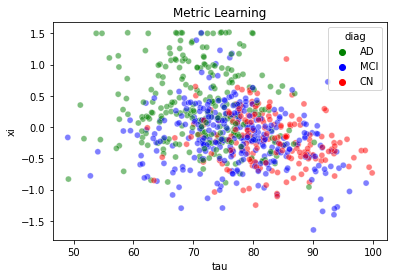

In [27]:
%matplotlib inline

sub_diag = sub_diag.loc[ip.index]
ip['diag'] = sub_diag['diag']
ip['label'] = sub_diag['label']

sns.scatterplot(data = ip,
                x = 'tau', 
                y = 'xi', 
                hue = 'diag',
                alpha=0.5, 
                palette = ['g', 'b', 'r'] )
plt.title('Metric Learning')
plt.show()

## Prediction task

In [512]:
import datetime

path = 'tadpole'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_tadpole.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [19]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

151 good iterations out of 152
175 good iterations out of 176


In [218]:
patients_to_predict = D4.index

In [527]:
forecast = pd.read_excel('tadpole/TADPOLE_Simple_Submission_Benoit.xlsx').rename(columns={'RID':'ID'}).set_index(['ID', 'Forecast Month'])

FileNotFoundError: [Errno 2] No such file or directory: 'tadpole/TADPOLE_Simple_Submission_Benoit.xlsx'

In [528]:
forecast

Forecast Date  CN relative probability  \
ID   Forecast Month                                          
2    1                    2018-01                      NaN   
     2                    2018-02                      NaN   
     3                    2018-03                      NaN   
     4                    2018-04                      NaN   
     5                    2018-05                      NaN   
...                           ...                      ...   
5296 56                   2022-08                      NaN   
     57                   2022-09                      NaN   
     58                   2022-10                      NaN   
     59                   2022-11                      NaN   
     60                   2022-12                      NaN   

                     MCI relative probability  AD relative probability  \
ID   Forecast Month                                                      
2    1                                    NaN                      NaN   
     2                                    NaN                      NaN   
     3                                    NaN                      NaN   
     4                                    NaN                      NaN   
     5                                    NaN                      NaN   
...                                       ...                      ...   
5296 56                                   NaN                      NaN   
     57                                   NaN                      NaN   
     58                                   NaN                      NaN   
     59                                   NaN                      NaN   
     60                                   NaN                      NaN   

                     ADAS13 50% CI lower  ADAS13 50% CI upper  \
ID   Forecast Month                                             
2    1                               NaN                  NaN   
     2                               NaN                  NaN   
     3                               NaN                  NaN   
     4                               NaN                  NaN   
     5                               NaN                  NaN   
...                                  ...                  ...   
5296 56                              NaN                  NaN   
     57                              NaN                  NaN   
     58                              NaN                  NaN   
     59                              NaN                  NaN   
     60                              NaN                  NaN   

                     Ventricles_ICV 50% CI lower  Ventricles_ICV 50% CI upper  
ID   Forecast Month                                                            
2    1                                       NaN                          NaN  
     2                                       NaN                          NaN  
     3                                       NaN                          NaN  
     4                                       NaN                          NaN  
     5                                       NaN                          NaN  
...                                          ...                          ...  
5296 56                                      NaN                          NaN  
     57                                      NaN                          NaN  
     58                                      NaN                          NaN  
     59                                      NaN                          NaN  
     60                                      NaN                          NaN  

[53760 rows x 8 columns]

In [655]:
pred = pd.DataFrame(columns=['Forecast Month', 'AGE', 'ADAS13', 'Ventricles_ICV'])

for sub in patients_to_predict:
    
    # Compute the number of months between last visit in D1 and beginning of forecast
    last_age = D1.loc[sub].iloc[-1].name
    y, m, d = int(ExamDates.loc[(sub,last_age)].values[0][:4]), int(ExamDates.loc[(sub,last_age)].values[0][5:7]), 1
    last_visit = datetime.datetime(y, m, d)
    y, m, d = int(forecast.loc[sub].iloc[0]['Forecast Date'][:4]), int(forecast.loc[sub].iloc[0]['Forecast Date'][5:7]), 1
    first_forecast = datetime.datetime(y, m, d)
    num_months = (first_forecast.year - last_visit.year) * 12 + (first_forecast.month - last_visit.month)
    
    if sub in ip.index:
        onset_age, log_acceleration, source = ip.loc[sub][['tau', 'xi', 'source']]

        predictions_i = []
        for i in range(60):
            forecast_age = last_age + (i+num_months)/12
            t = np.exp(log_acceleration) * (forecast_age - onset_age) + model.fixed_effects['reference_time']
            prediction = model.spatiotemporal_reference_frame.get_position(torch.tensor(t), sources=[source])
            predictions_i.append(prediction)
        data_sub = pd.DataFrame(columns=['Forecast Month', 'AGE', 'ADAS13', 'Ventricles_ICV'])
        data_sub['Forecast Month'] = [i for i in range(1,61)]
        data_sub['AGE'] = [last_age + (i+num_months)/12 for i in range(60)]
        data_sub['ADAS13'] = [float(prediction[0]) for prediction in predictions_i]
        data_sub['Ventricles_ICV'] = [float(prediction[1]) for prediction in predictions_i]
        data_sub.index = [sub for i in range(60)]

        #data_sub.columns = ['ADAS13', 'Ventricles_ICV', 'Hippocampus_ICV']
        pred = pred.append(data_sub)
    else:
        print(sub)
pred['ID'] = pred.index
pred = pred.set_index(['ID', 'Forecast Month'])
pred

/tmp/ipykernel_2648412/1980181560.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  y, m, d = int(ExamDates.loc[(sub,last_age)].values[0][:4]), int(ExamDates.loc[(sub,last_age)].values[0][5:7]), 1


205
555
555
1352
2130
2185
2308
2333
2374
2380
2392
2394
2395
4090
4138
4149
4170
4176
4176
4177
4179
4179
4197
4224
4229
4277
4290
4294
4332
4345
4349
4376
4384
4422
4430
4431
4485
4489
4499
4506
4507
4538
4548
4580
4585
4607
4620
4649
4706
4721
4767
4835
4855
4855
4856
4862
4869
4869
4872
4891
4896
4902
4926
5004
5040
5091
5097
5100
5124
5135
5154
5157
5158
5171
5177
5194
5195
5198
5203
5219
5219
5230
5234
5237
5243
5259
5265
5266
5272
5278
5282
5285
5288
5289
5290
5292
5294
5296


AGE    ADAS13  Ventricles_ICV
ID   Forecast Month                                     
21   1               84.850000  0.167532        0.287889
     2               84.933333  0.168158        0.288829
     3               85.016667  0.168706        0.289675
     4               85.100000  0.169201        0.290458
     5               85.183333  0.169702        0.291248
...                        ...       ...             ...
5093 56              78.716667  0.184229        0.326908
     57              78.800000  0.184738        0.327685
     58              78.883333  0.185339        0.328541
     59              78.966667  0.185945        0.329402
     60              79.050000  0.186546        0.330260

[8160 rows x 3 columns]

In [656]:
if 'ADAS13' in forecast.columns:
    forecast = forecast.drop(['ADAS13', 'Ventricles_ICV'], axis=1)
estimated_D4 = forecast.join(pred, on=['ID', 'Forecast Month']).drop(['AGE'], axis=1)

In [657]:
estimated_D4.loc[259]

,Forecast Date,CN relative probability,MCI relative probability,AD relative probability,ADAS13 50% CI lower,ADAS13 50% CI upper,Ventricles_ICV 50% CI lower,Ventricles_ICV 50% CI upper,ADAS13,Ventricles_ICV
Forecast Month,,,,,,,,,,
1,2018-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381712,0.723539
2,2018-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384080,0.726403
3,2018-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.385894,0.727437
4,2018-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387949,0.729165
5,2018-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390247,0.731609
6,2018-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.391909,0.732486
7,2018-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.394116,0.734743
8,2018-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.396161,0.736504
9,2018-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.397834,0.737258


In [688]:
estimated_D4['ADAS13'] = 50 * estimated_D4['ADAS13']
estimated_D4['Ventricles_ICV'] = 0.06 * estimated_D4['Ventricles_ICV']

In [637]:
estimated_D4.index = estimated_D4.index.set_names(['RID', 'Forecast Month'])
estimated_D4.to_csv('tadpole/TADPOLE_Submission_Benoit.csv')

### Compare locally D4 and estimated_D4

In [704]:
columns = ['RID', 'AGE', 'Ventricles', 'ADAS13', 'ICV', 'ScanDate']
D4 = pd.read_csv(path+'TADPOLE_D4_corr.csv').set_index('RID')

In [705]:
formatted_dates = [data[:7] for data in D4['ScanDate'].values]
D4['ScanDate'] = formatted_dates
D4 = D4.rename(columns={'ScanDate' : 'Forecast Date', 'Ventricles' : 'Ventricles_ICV'})
D4['RID'] = D4.index
D4 = D4.set_index(['RID', 'Forecast Date'])
D4 = D4[['ADAS13', 'Ventricles_ICV']].dropna()

In [706]:
D4

ADAS13  Ventricles_ICV
RID  Forecast Date                        
31   2018-04         14.00        0.029783
56   2019-01         14.00        0.018841
69   2018-01         19.00        0.030050
     2019-01         22.00        0.030151
74   2019-01         17.67        0.053344
...                    ...             ...
5285 2018-10         22.00        0.062427
5289 2018-05         15.67        0.026308
5290 2018-10          6.00        0.011296
5292 2018-09         15.33        0.017878
5296 2018-11         15.00        0.015177

[141 rows x 2 columns]

In [707]:
estimated_D4_local = estimated_D4.copy()
estimated_D4_local['RID'] = estimated_D4_local.index.get_level_values(0)
estimated_D4_local = estimated_D4_local.set_index(['RID', 'Forecast Date'])

In [711]:
commun_subs = [visit for visit in D4.index if visit in estimated_D4_local.index]
abs(D4 - estimated_D4_local)[['ADAS13', 'Ventricles_ICV']].describe(percentiles=[.25,.5,.75,.85,.95])

,ADAS13,Ventricles_ICV
count,98.000000,98.000000
mean,5.028360,0.004943
std,5.689668,0.005825
min,0.078850,0.000015
25%,1.502051,0.001680
50%,3.432146,0.003011
75%,6.117341,0.005896
85%,8.673800,0.007740
95%,17.124135,0.016590
max,30.237418,0.030600


In [714]:
D4

ADAS13  Ventricles_ICV
RID  Forecast Date                        
31   2018-04         14.00        0.029783
56   2019-01         14.00        0.018841
69   2018-01         19.00        0.030050
     2019-01         22.00        0.030151
74   2019-01         17.67        0.053344
...                    ...             ...
5285 2018-10         22.00        0.062427
5289 2018-05         15.67        0.026308
5290 2018-10          6.00        0.011296
5292 2018-09         15.33        0.017878
5296 2018-11         15.00        0.015177

[141 rows x 2 columns]

In [716]:
estimated_D4_local.loc[commun_subs]

CN relative probability  MCI relative probability  \
RID  Forecast Date                                                      
31   2018-04                            NaN                       NaN   
56   2019-01                            NaN                       NaN   
69   2018-01                            NaN                       NaN   
     2018-01                            NaN                       NaN   
     2019-01                            NaN                       NaN   
...                                     ...                       ...   
5285 2018-10                            NaN                       NaN   
5289 2018-05                            NaN                       NaN   
5290 2018-10                            NaN                       NaN   
5292 2018-09                            NaN                       NaN   
5296 2018-11                            NaN                       NaN   

                    AD relative probability  ADAS13 50% CI lower  \
RID  Forecast Date                                                 
31   2018-04                            NaN                  NaN   
56   2019-01                            NaN                  NaN   
69   2018-01                            NaN                  NaN   
     2018-01                            NaN                  NaN   
     2019-01                            NaN                  NaN   
...                                     ...                  ...   
5285 2018-10                            NaN                  NaN   
5289 2018-05                            NaN                  NaN   
5290 2018-10                            NaN                  NaN   
5292 2018-09                            NaN                  NaN   
5296 2018-11                            NaN                  NaN   

                    ADAS13 50% CI upper  Ventricles_ICV 50% CI lower  \
RID  Forecast Date                                                     
31   2018-04                        NaN                          NaN   
56   2019-01                        NaN                          NaN   
69   2018-01                        NaN                          NaN   
     2018-01                        NaN                          NaN   
     2019-01                        NaN                          NaN   
...                                 ...                          ...   
5285 2018-10                        NaN                          NaN   
5289 2018-05                        NaN                          NaN   
5290 2018-10                        NaN                          NaN   
5292 2018-09                        NaN                          NaN   
5296 2018-11                        NaN                          NaN   

                    Ventricles_ICV 50% CI upper     ADAS13  Ventricles_ICV  
RID  Forecast Date                                                          
31   2018-04                                NaN   6.217963        0.023091  
56   2019-01                                NaN  10.058752        0.017848  
69   2018-01                                NaN  20.355506        0.030650  
     2018-01                                NaN  20.355506        0.030650  
     2019-01                                NaN  21.464266        0.031969  
...                                         ...        ...             ...  
5285 2018-10                                NaN        NaN             NaN  
5289 2018-05                                NaN        NaN             NaN  
5290 2018-10                                NaN        NaN             NaN  
5292 2018-09                                NaN        NaN             NaN  
5296 2018-11                                NaN        NaN             NaN  

[155 rows x 9 columns]

In [647]:
D4.describe(percentiles=[.25,.5,.8,.9,.95,.98])

,LB4,ADAS13,Ventricles,AGE,MMSE,Years_bl
count,234.0,219.000000,150.000000,234.000000,223.000000,234.000000
mean,1.0,18.750274,0.029805,79.572165,27.291480,0.077432
std,0.0,9.522416,0.013205,7.267112,4.318436,0.268910
min,1.0,5.670000,0.006354,62.129360,5.000000,0.000000
25%,1.0,11.670000,0.019420,74.607703,27.000000,0.000000
50%,1.0,16.330000,0.028260,80.071320,29.000000,0.000000
80%,1.0,24.598000,0.038272,85.812428,30.000000,0.000000
90%,1.0,30.134000,0.048255,89.359919,30.000000,0.000000
95%,1.0,38.033000,0.058399,91.151873,30.000000,0.997545
98%,1.0,43.708800,0.062259,92.918554,30.000000,1.014870


In [648]:
estimated_D4[['ADAS13','Ventricles_ICV']].describe(percentiles=[.25,.5,.8,.9,.95,.98])

,ADAS13,Ventricles_ICV
count,8160.000000,8160.000000
mean,16.316561,0.029624
std,8.131393,0.011906
min,4.211658,0.011780
25%,10.935972,0.019274
50%,14.181135,0.027613
80%,22.456610,0.039022
90%,25.817498,0.048763
95%,30.368533,0.053733
98%,41.231959,0.057895
